In [1]:
import torch
from models.model_utils import npdat2Tensor
def fetch_data(data_paths, batchsize, shuffle=True):
    print("setting up data")

    train_loaders = []
    for path in data_paths:
        npz_PropS = np.load(path)
        inputdata = torch.stack((npdat2Tensor(npz_PropS['Ucx']),
                                 npdat2Tensor(npz_PropS['Ucy']),
                                 npdat2Tensor(npz_PropS['Utc']),
                                 npdat2Tensor(npz_PropS['vel'])), dim=1)
        outputdata = torch.stack((npdat2Tensor(npz_PropS['Ufx']),
                                  npdat2Tensor(npz_PropS['Ufy']),
                                  npdat2Tensor(npz_PropS['Utf'])), dim=1)
        data_loader = torch.utils.data.DataLoader(torch.utils.data.TensorDataset(inputdata, outputdata),
                                                  batch_size=batchsize, shuffle=shuffle, num_workers=1)
        train_loaders.append(data_loader)

    return train_loaders

In [2]:
from models.model_utils import load_model
from models.unet import UNet
from models.tiramisu import FCDenseNet
import matplotlib.pyplot as plt
import numpy as np

#models
model_unet = UNet().double()
load_model("../results/run_1/saved_model_unet9.pt", model_unet)
model_tir = FCDenseNet().double()
#load_model("../results/run_1/saved_model_tiramisu9.pt", model_tir)

#data
data_paths = ['../data/training_data_12.npz']
train_loaders = fetch_data(data_paths, batchsize=1, shuffle=False)

setting up data


In [3]:
#getting one specific image
for train_loader in train_loaders:
    for i, data in enumerate(train_loader):
        if i == 1: #802
            inputs, labels = data[0], data[1]
            outputs_unet = model_unet(inputs)
            output_tiramisu = model_tir(inputs)
            print(output_tiramisu.shape)
            break

torch.Size([1, 3, 256, 256])


In [ ]:
# compare physical components for single image

from mounted.WaveUtil import WaveSol_from_EnergyComponent
from skimage.transform import resize

l = [
    inputs[0], # wave energy component coarse solver (inputs),
    outputs_unet[0], # wave energy component enhanced through unet
    output_tiramisu[0], # wave energy component enhanced through unet
    labels[0] # # wave energy component fine solver (label)
]
f, ax = plt.subplots(1,4)
f.set_figheight(20)
f.set_figwidth(20)
d = inputs[0][3,:,:].detach().numpy()
d2 = resize(d,(256,256)) # have it to same resolution as output img

for i, img in enumerate(l):
    if i != 0:
        d = d2
    a,b,c = img[0,:,:].detach().numpy(), img[1,:,:].detach().numpy(), img[2,:,:].detach().numpy()
    res = WaveSol_from_EnergyComponent(a,b,c,d, .1, 0) # capital lambda dagger
    ax[i].imshow(res[0])

ax[0].set_title('coarse solver (input)')
ax[1].set_title('nn unet, 3lvl (output)')
ax[2].set_title('nn tiramisu, 3lvl (output)')
ax[3].set_title('fine solver (label)')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([4, 64, 64])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])
torch.Size([3, 256, 256])


Text(0.5, 1.0, 'fine solver (label)')

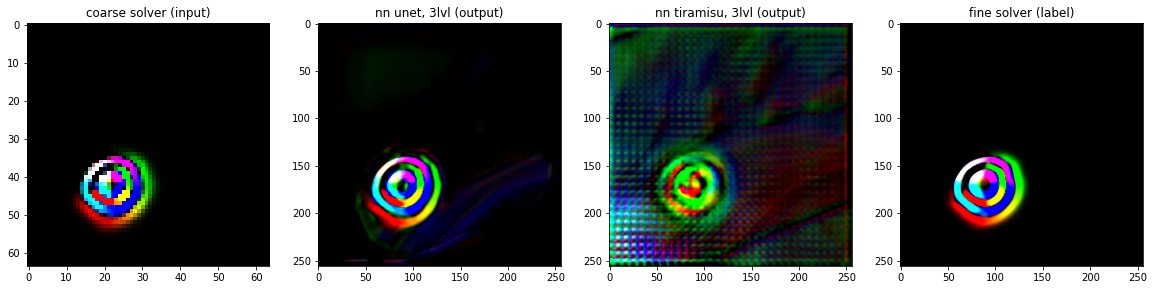

In [4]:
# compare energy components for single image

l = [
    inputs[0], # wave energy component coarse solver (inputs),
    outputs_unet[0], # wave energy component enhanced through unet
    output_tiramisu[0], # wave energy component enhanced through unet
    labels[0] # # wave energy component fine solver (label)
]
f, ax = plt.subplots(1,4)
f.set_figheight(20)
f.set_figwidth(20)

for i, img in enumerate(l):
    print(img.shape)
    ax[i].imshow(img.permute(1,2,0).detach().numpy())

ax[0].set_title('coarse solver (input)')
ax[1].set_title('nn unet, 3lvl (output)')
ax[2].set_title('nn tiramisu, 3lvl (output)')
ax[3].set_title('fine solver (label)')

In [312]:
#from mounted.WavePostprocess4input import ApplyNet2WaveSol

#ApplyNet2WaveSol() #w0,wt0,w,wt,c,dx,net